In [1]:
# # %pip install --quiet --force-reinstall torchmetrics==1.3.2
# !pip install -q pytorch-grad-cam
# !pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

!pip install -U scikit-image==0.21.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 72.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.25.2
    Uninstalling scikit-image-0.25.2:
      Successfully uninstalled scikit-image-0.25.2


In [4]:
# -----------------------------
# Imports (Updated & Clean)
# -----------------------------
import os
from pathlib import Path
import random
import numpy as np
from glob import glob
from collections import Counter

import warnings
warnings.filterwarnings("ignore", message=".*can only test a child process.*")

import torch
torch.multiprocessing.set_sharing_strategy('file_system')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
import torchvision.transforms as T
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve
)
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from torchmetrics.classification import MulticlassAccuracy
# Import Libraries 

import os
from pathlib import Path
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T
import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

import shap
from torchvision import models
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image

from sklearn.metrics import accuracy_score
import cv2
from torchvision.utils import make_grid

In [9]:
import os
from pathlib import Path
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.filters import sobel  # for edge detection

sns.set(style="whitegrid")

def collect_image_paths(base_path, class_names):
    """Return dict: class → list of image file paths."""
    base = Path(base_path)
    image_paths = {cls: list((base / cls).glob("*")) for cls in class_names}
    return image_paths

def print_class_counts(image_paths):
    print(" Class-wise image count:")
    for cls, imgs in image_paths.items():
        print(f"  {cls}: {len(imgs)} images")

def plot_random_samples(image_paths, n_samples=5, figsize=(15, 9)):
    print("\n Plotting random sample images from each class...")
    classes = list(image_paths.keys())
    fig, axes = plt.subplots(len(classes), n_samples, figsize=figsize)
    for i, cls in enumerate(classes):
        imgs = image_paths[cls]
        if len(imgs) == 0:
            continue
        samples = random.sample(imgs, min(n_samples, len(imgs)))
        for j, img_path in enumerate(samples):
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            if j == n_samples // 2:
                axes[i, j].set_title(cls)
    plt.tight_layout()
    plt.show()

def compute_size_stats(image_paths):
    widths = []
    heights = []
    aspect_ratios = []
    for imgs in image_paths.values():
        for p in imgs:
            with Image.open(p) as img:
                widths.append(img.width)
                heights.append(img.height)
                aspect_ratios.append(img.width / img.height)
    return widths, heights, aspect_ratios

def plot_size_distributions(widths, heights, aspect_ratios):
    print("\n Plotting image size distributions: width, height, aspect ratio...")
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    sns.histplot(widths, bins=30, kde=True)
    plt.title("Image Width Distribution")
    plt.subplot(1, 3, 2)
    sns.histplot(heights, bins=30, kde=True)
    plt.title("Image Height Distribution")
    plt.subplot(1, 3, 3)
    sns.histplot(aspect_ratios, bins=30, kde=True)
    plt.title("Aspect Ratio Distribution")
    plt.show()

def compute_color_channel_stats(image_paths, sample_limit=1000):
    means_r = []
    means_g = []
    means_b = []
    for imgs in image_paths.values():
        for p in imgs[:sample_limit]:
            with Image.open(p) as img:
                arr = np.array(img.convert("RGB"))
                means_r.append(np.mean(arr[:, :, 0]))
                means_g.append(np.mean(arr[:, :, 1]))
                means_b.append(np.mean(arr[:, :, 2]))
    return means_r, means_g, means_b

def plot_color_channel(means_r, means_g, means_b):
    print("\n Plotting mean color intensity distributions for RGB channels...")
    plt.figure(figsize=(8, 5))
    sns.kdeplot(means_r, label="Red")
    sns.kdeplot(means_g, label="Green")
    sns.kdeplot(means_b, label="Blue")
    plt.title("Mean Color Channel Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

def compute_brightness_contrast(image_paths, sample_limit=1000):
    brightness = []
    contrast = []
    for imgs in image_paths.values():
        for p in imgs[:sample_limit]:
            with Image.open(p) as img:
                gray = np.array(img.convert("L"))
                brightness.append(gray.mean())
                contrast.append(gray.std())
    return brightness, contrast

def plot_brightness_contrast(brightness, contrast):
    print("\n Plotting brightness and contrast distributions...")
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(brightness, bins=30, kde=True, color="orange")
    plt.title("Brightness Distribution")
    plt.subplot(1, 2, 2)
    sns.histplot(contrast, bins=30, kde=True, color="purple")
    plt.title("Contrast Distribution")
    plt.show()

def show_class_average_images(image_paths, target_size=(224, 224), sample_limit=100):
    print("\n Showing average image per class (pixel-wise mean of resized images)...")
    for cls, imgs in image_paths.items():
        if len(imgs) == 0:
            continue
        avg_img = np.zeros((target_size[1], target_size[0], 3), dtype=np.float32)
        count = 0
        for p in imgs[:sample_limit]:
            with Image.open(p) as img:
                arr = np.array(img.resize(target_size))
                avg_img += arr
                count += 1
        avg_img = (avg_img / count).astype(np.uint8)
        plt.imshow(avg_img)
        plt.title(f"Avg Image – {cls}")
        plt.axis("off")
        plt.show()

def edge_pattern_per_class(image_paths, classes, n_per_class=3, target_size=(224, 224)):
    print("\n Plotting edge detection patterns (Sobel) per class...")
    plt.figure(figsize=(15, 9))
    for i, cls in enumerate(classes):
        imgs = image_paths[cls]
        samples = random.sample(imgs, min(n_per_class, len(imgs)))
        for j, p in enumerate(samples):
            with Image.open(p) as img:
                gray = np.array(img.convert("L").resize(target_size))
                edge = sobel(gray)
            ax = plt.subplot(len(classes), n_per_class, i * n_per_class + j + 1)
            ax.imshow(edge, cmap="gray")
            if j == n_per_class // 2:
                ax.set_title(cls)
            ax.axis("off")
    plt.suptitle("Edge Patterns per Class (Sobel)")
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

def summarize_per_class(image_paths, brightness_dict=None, contrast_dict=None):
    print("\n Summary statistics per class:")
    for cls, imgs in image_paths.items():
        print(f"\nClass: {cls}")
        print(f"Image count: {len(imgs)}")
        if len(imgs) == 0:
            continue

        # widths / heights
        widths = [Image.open(p).width for p in imgs]
        heights = [Image.open(p).height for p in imgs]
        print(f"Width: min {min(widths)}, max {max(widths)}")
        print(f"Height: min {min(heights)}, max {max(heights)}")

        if brightness_dict is not None and contrast_dict is not None:
            b = brightness_dict.get(cls, [])
            c = contrast_dict.get(cls, [])
            if len(b) > 0:
                print(f"Brightness: mean {np.mean(b):.2f}, std {np.std(b):.2f}")
            if len(c) > 0:
                print(f"Contrast: mean {np.mean(c):.2f}, std {np.std(c):.2f}")

def complete_eda(base_path, class_names):
    """Run full EDA pipeline given base path and class folder names."""
    print(" Starting Complete EDA...\n")
    image_paths = collect_image_paths(base_path, class_names)
    
    print_class_counts(image_paths)
    plot_random_samples(image_paths)
    
    widths, heights, aspect_ratios = compute_size_stats(image_paths)
    plot_size_distributions(widths, heights, aspect_ratios)
    
    means_r, means_g, means_b = compute_color_channel_stats(image_paths)
    plot_color_channel(means_r, means_g, means_b)
    
    brightness, contrast = compute_brightness_contrast(image_paths)
    plot_brightness_contrast(brightness, contrast)
    
    show_class_average_images(image_paths)
    edge_pattern_per_class(image_paths, class_names)

    # Per-class brightness/contrast breakdown
    brightness_dict = {}
    contrast_dict = {}
    for cls in class_names:
        br, cr = compute_brightness_contrast({cls: image_paths[cls]})
        brightness_dict[cls] = br
        contrast_dict[cls] = cr
    summarize_per_class(image_paths, brightness_dict, contrast_dict)

    # Optionally: build a DataFrame with all images + metadata
    print("\n📄 Creating metadata DataFrame with width, height, aspect ratio, class, and path...")
    records = []
    for cls, imgs in image_paths.items():
        for p in imgs:
            with Image.open(p) as img:
                w, h = img.size
            records.append({
                "path": str(p),
                "class": cls,
                "width": w,
                "height": h,
                "aspect_ratio": w / h
            })
    df = pd.DataFrame(records)
    print("Metadata DataFrame created.")
    return df


 Starting Complete EDA...

 Class-wise image count:
  melanoma_in_situ: 850 images
  melanoma_invasive: 797 images
  nevus: 800 images

🖼️ Plotting random sample images from each class...


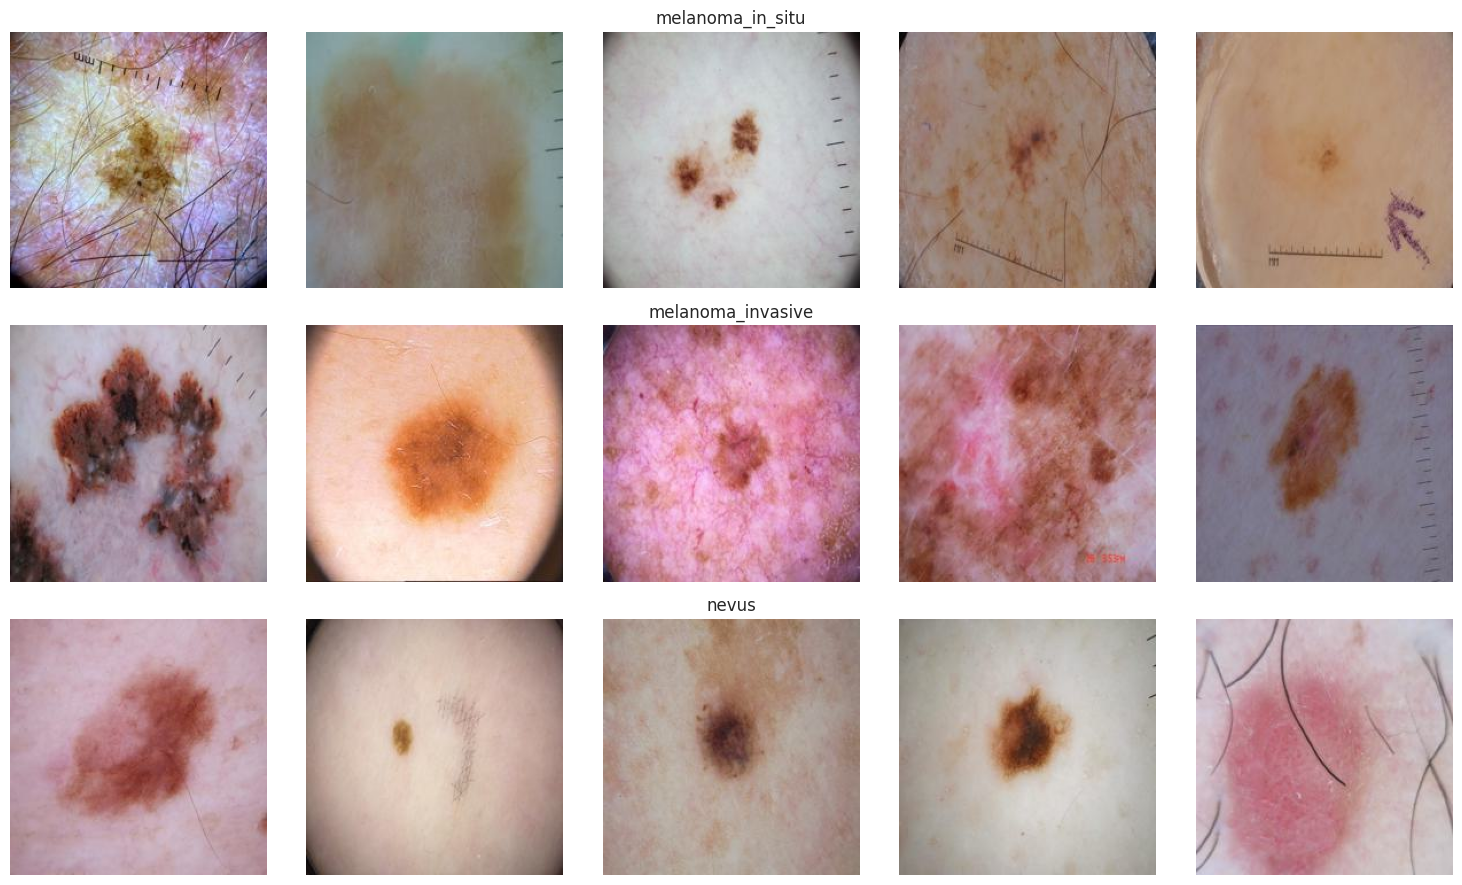


 Plotting image size distributions: width, height, aspect ratio...


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


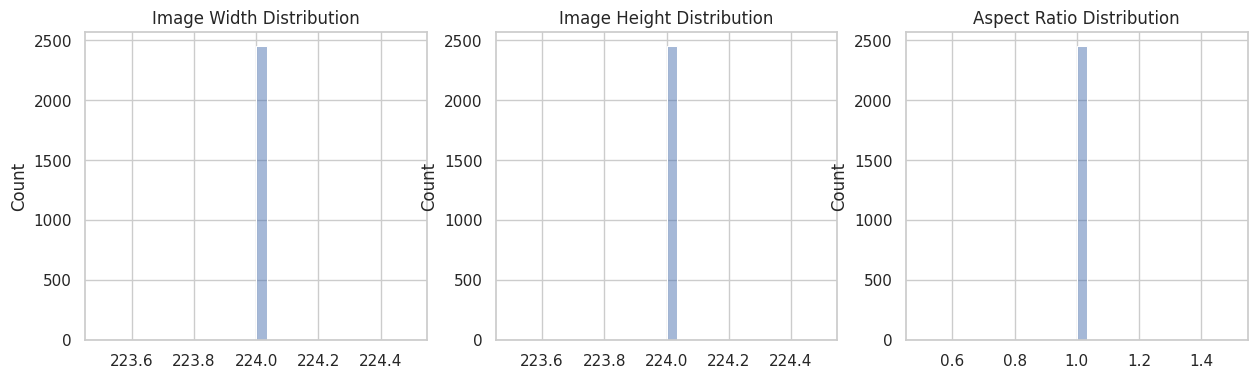


 Plotting mean color intensity distributions for RGB channels...


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


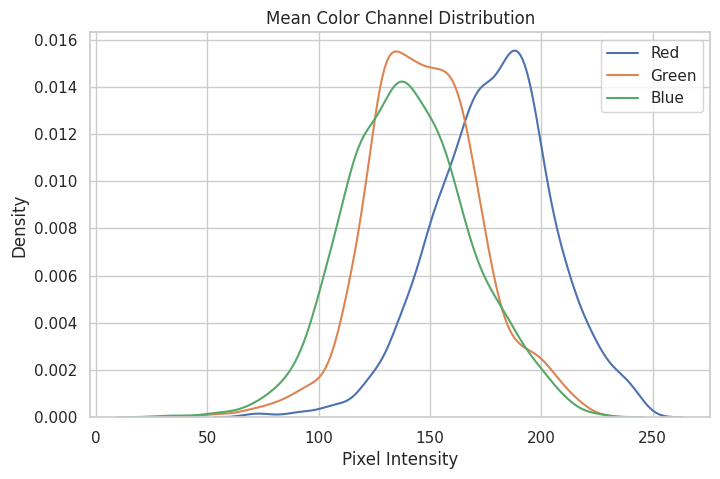


 Plotting brightness and contrast distributions...


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


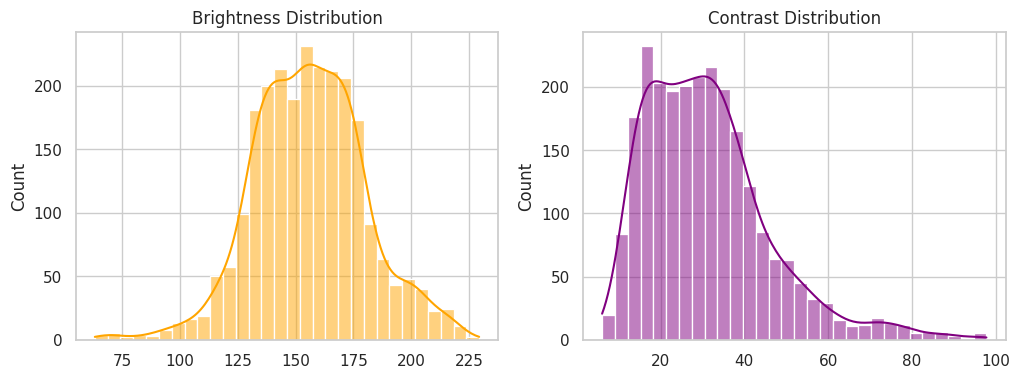


 Showing average image per class (pixel-wise mean of resized images)...


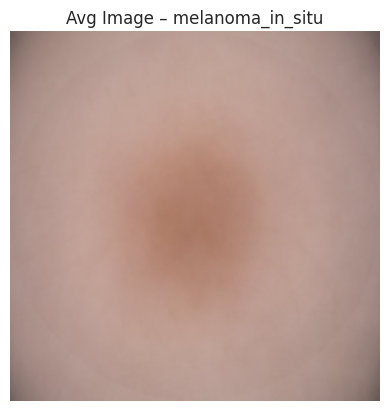

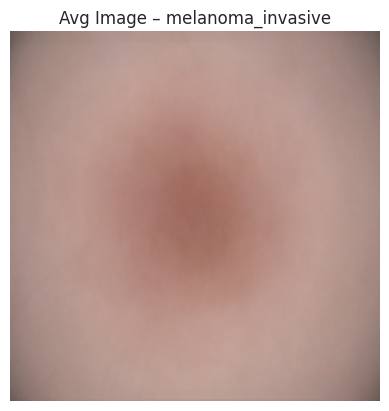

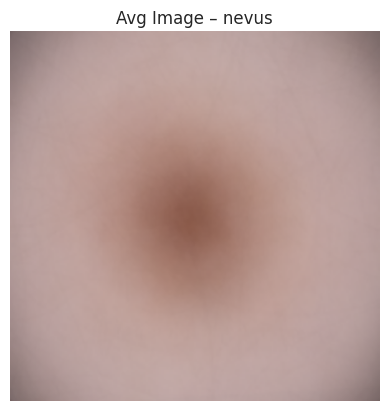


 Plotting edge detection patterns (Sobel) per class...


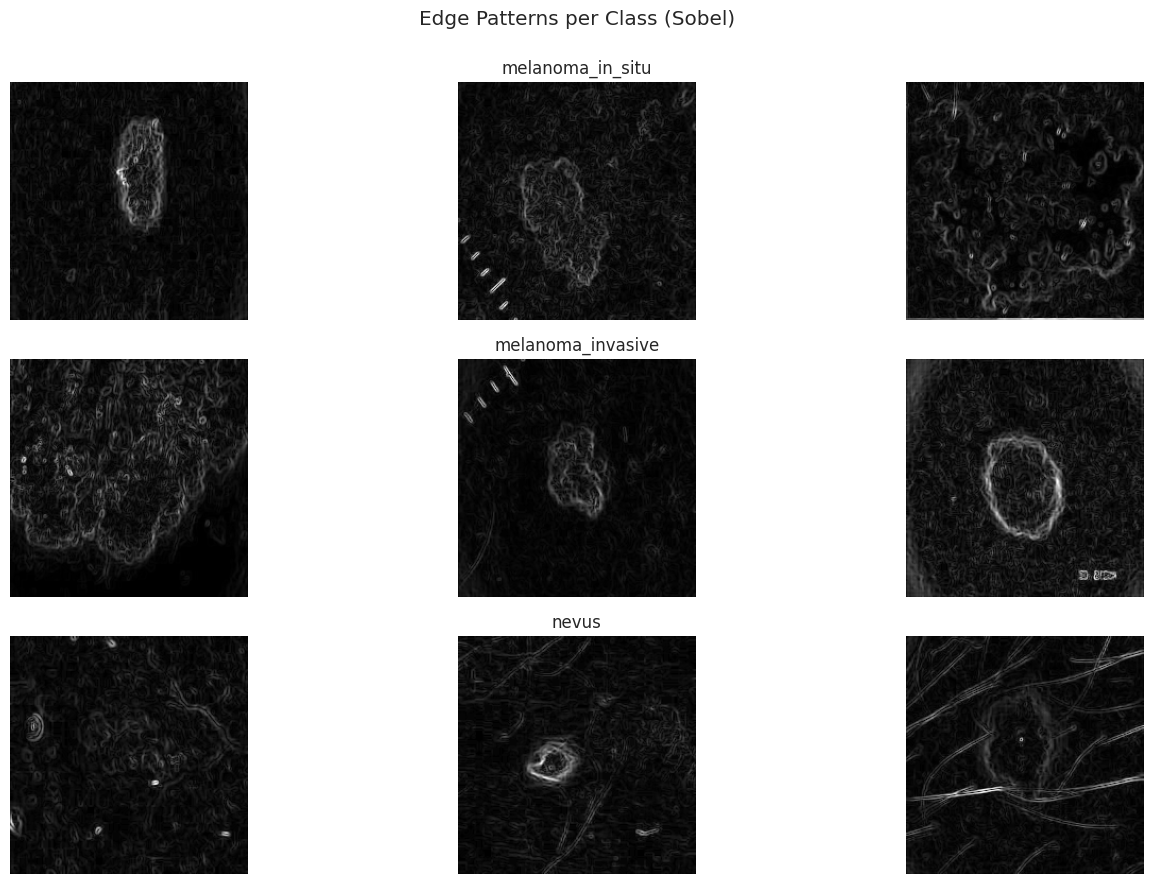


 Summary statistics per class:

Class: melanoma_in_situ
Image count: 850
Width: min 224, max 224
Height: min 224, max 224
Brightness: mean 156.45, std 22.77
Contrast: mean 28.02, std 13.02

Class: melanoma_invasive
Image count: 797
Width: min 224, max 224
Height: min 224, max 224
Brightness: mean 150.94, std 25.12
Contrast: mean 31.56, std 15.98

Class: nevus
Image count: 800
Width: min 224, max 224
Height: min 224, max 224
Brightness: mean 160.19, std 23.72
Contrast: mean 33.96, std 15.15

📄 Creating metadata DataFrame with width, height, aspect ratio, class, and path...
Metadata DataFrame created.


In [8]:
base_path = r"/kaggle/input/melanoma-balanced-resized-verion-04/melanoma_balanced_resized_verion 04"
class_names = ["melanoma_in_situ", "melanoma_invasive", "nevus"]
df_metadata = complete_eda(base_path, class_names)


In [10]:
import os
from pathlib import Path
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops  # ✅ works
from skimage import color
from sklearn.decomposition import PCA
import torch
import torchvision.transforms as T
import timm

sns.set(style='whitegrid')

def texture_glcm_features(img_gray, distances=[1,2,3], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    """Compute GLCM features: contrast, dissimilarity, homogeneity, energy, correlation."""
    glcm = graycomatrix(img_gray, distances=distances, angles=angles, symmetric=True, normed=True)
    feats = {}
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    for prop in props:
        arr = graycoprops(glcm, prop)
        feats[prop] = arr.mean()
    return feats

def sharpness(img_gray):
    """Measure blur / sharpness using variance of Laplacian."""
    import cv2
    arr = np.array(img_gray, dtype=np.uint8)
    lap = cv2.Laplacian(arr, cv2.CV_64F)
    return lap.var()

def get_embeddings(image_paths, model_name='resnet50', device='cuda' if torch.cuda.is_available() else 'cpu', size=(224,224)):
    model = timm.create_model(model_name, pretrained=True)
    # remove final classifier head
    model = torch.nn.Sequential(*list(model.children())[:-1])
    model.eval().to(device)
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
    ])
    embeddings = []
    labels = []
    for cls, paths in image_paths.items():
        for p in random.sample(paths, min(len(paths), 200)):  # sample some for speed
            img = Image.open(p).convert('RGB')
            x = transform(img).unsqueeze(0).to(device)
            with torch.no_grad():
                emb = model(x).squeeze().cpu().numpy()
            embeddings.append(emb)
            labels.append(cls)
    embeddings = np.array(embeddings).reshape(len(embeddings), -1)
    return embeddings, labels

def plot_embedding(embeddings, labels, method='PCA'):
    print(f"\nPlotting {method} embedding of image features...")
    if method=='PCA':
        red = PCA(n_components=2).fit_transform(embeddings)
    else:
        import umap
        red = umap.UMAP(n_components=2).fit_transform(embeddings)
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=red[:,0], y=red[:,1], hue=labels, alpha=0.7, s=50)
    plt.title(f'{method} Embedding of Images')
    plt.show()

def enhanced_eda(base_path, class_names):
    image_paths = collect_image_paths(base_path, class_names)
    print_class_counts(image_paths)

    # texture & sharpness features
    texture_feats = {cls: [] for cls in class_names}
    sharpness_vals = {cls: [] for cls in class_names}
    
    print("\nExtracting texture (GLCM) and sharpness features from images...")
    for cls, paths in image_paths.items():
        for p in random.sample(paths, min(200, len(paths))):
            img = Image.open(p).convert('L').resize((256,256))
            arr = np.array(img)
            # Compute GLCM features
            feats = texture_glcm_features(arr)
            texture_feats[cls].append(feats)
            # Compute sharpness
            sharpness_vals[cls].append(sharpness(arr))

    print("\nPlotting sharpness / blur distributions per class...")
    plt.figure(figsize=(8,5))
    for cls in class_names:
        sns.kdeplot(sharpness_vals[cls], label=cls)
    plt.title("Sharpness / Blur Distribution per Class")
    plt.legend()
    plt.show()

    print("\nGenerating deep feature embeddings for images using pretrained ResNet50...")
    embeddings, labels = get_embeddings(image_paths, model_name='resnet50')
    plot_embedding(embeddings, labels, method='PCA')
    # if you install umap, you can also do method='UMAP'

    # Sample weird / extreme images
    print("\nIdentifying and displaying images with extreme aspect ratios per class...")
    extremes = []
    for cls, paths in image_paths.items():
        paths_sorted_aspect = sorted(paths, key=lambda p: Image.open(p).width / Image.open(p).height)
        # pick extremes
        extremes.append(('min_aspect_'+cls, paths_sorted_aspect[0]))
        extremes.append(('max_aspect_'+cls, paths_sorted_aspect[-1]))

    fig, axes = plt.subplots(len(extremes), 1, figsize=(6, len(extremes)*3))
    for i, (name, p) in enumerate(extremes):
        img = Image.open(p)
        axes[i].imshow(img)
        axes[i].set_title(name)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

    # Lesion vs background color and brightness if segmentation available
    # If you have mask images, do per-pixel inside/outside stats



 Class-wise image count:
  melanoma_in_situ: 850 images
  melanoma_invasive: 797 images
  nevus: 800 images

Extracting texture (GLCM) and sharpness features from images...

Plotting sharpness / blur distributions per class...


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


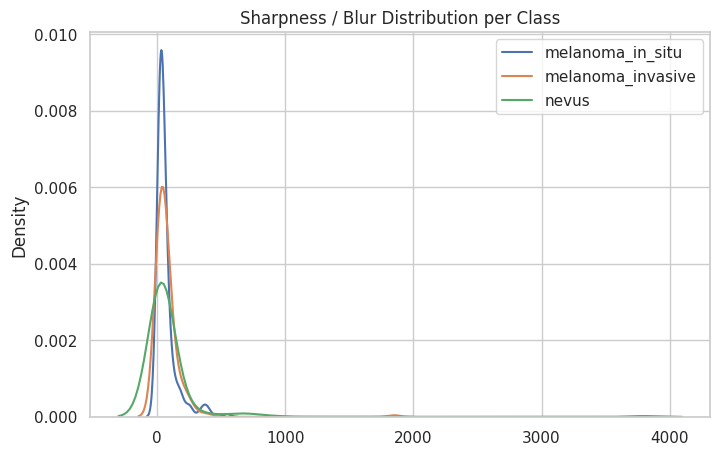


Generating deep feature embeddings for images using pretrained ResNet50...


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]


Plotting PCA embedding of image features...


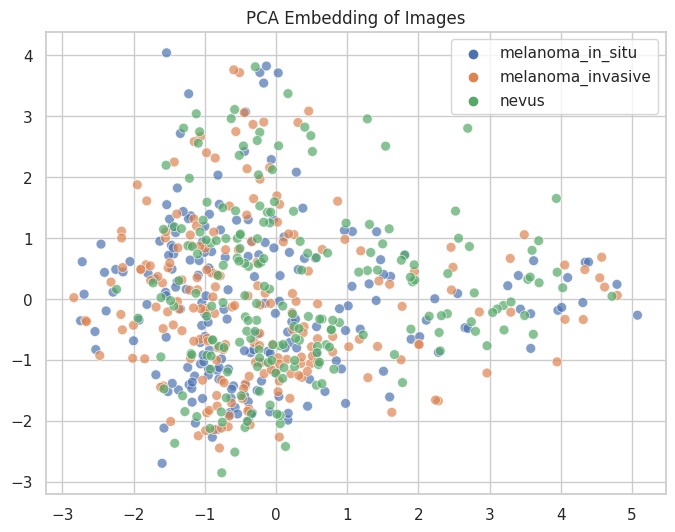


Identifying and displaying images with extreme aspect ratios per class...


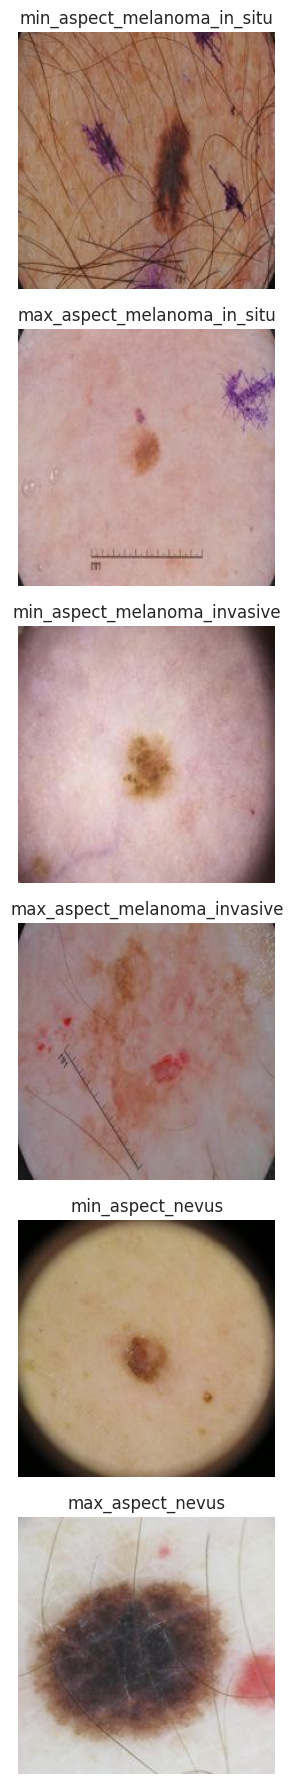

In [11]:
# Example usage:
if __name__ == "__main__":
    base_path = r"/kaggle/input/melanoma-balanced-resized-verion-04/melanoma_balanced_resized_verion 04"
    class_names = ["melanoma_in_situ", "melanoma_invasive", "nevus"]
    enhanced_eda(base_path, class_names)


In [12]:
base_path = r"/kaggle/input/melanoma-balanced-resized-verion-04/melanoma_balanced_resized_verion 04"

label_folders = {
    'melanoma_in_situ': os.path.join(base_path, "melanoma_in_situ"),
    'melanoma_invasive': os.path.join(base_path, "melanoma_invasive"),
    'nevus': os.path.join(base_path, "nevus")
}

data = []

for label, folder in label_folders.items():
    for file in os.listdir(folder):
        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
            data.append({
                'image_path': os.path.join(folder, file),
                'label': label
            })

df = pd.DataFrame(data)
print(f"\nTotal Images: {len(df)}")
df.head()


Total Images: 2447


image_path             label
0  /kaggle/input/melanoma-balanced-resized-verion...  melanoma_in_situ
1  /kaggle/input/melanoma-balanced-resized-verion...  melanoma_in_situ
2  /kaggle/input/melanoma-balanced-resized-verion...  melanoma_in_situ
3  /kaggle/input/melanoma-balanced-resized-verion...  melanoma_in_situ
4  /kaggle/input/melanoma-balanced-resized-verion...  melanoma_in_situ

### Image Dimensions & Aspect Ratio Analysis

100%|██████████| 2447/2447 [00:01<00:00, 1614.56it/s]


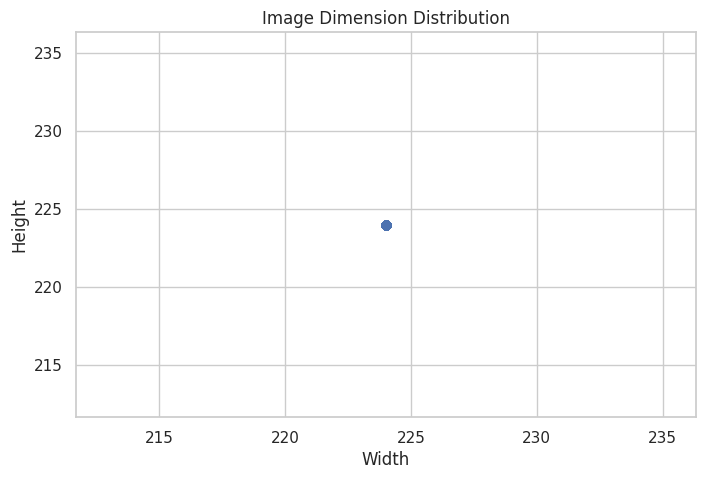

Unique image sizes: width  height
224    224       2447
Name: count, dtype: int64


In [13]:

dims = []
for path in tqdm(df['image_path']):
    img = Image.open(path)
    dims.append(img.size)  # (width, height)

df['width'], df['height'] = zip(*dims)

plt.figure(figsize=(8,5))
plt.scatter(df['width'], df['height'], alpha=0.3)
plt.title("Image Dimension Distribution")
plt.xlabel("Width")
plt.ylabel("Height")
plt.grid(True)
plt.show()

print("Unique image sizes:", df[['width', 'height']].value_counts().head())


### Average Pixel Intensity (Grayscale Analysis)

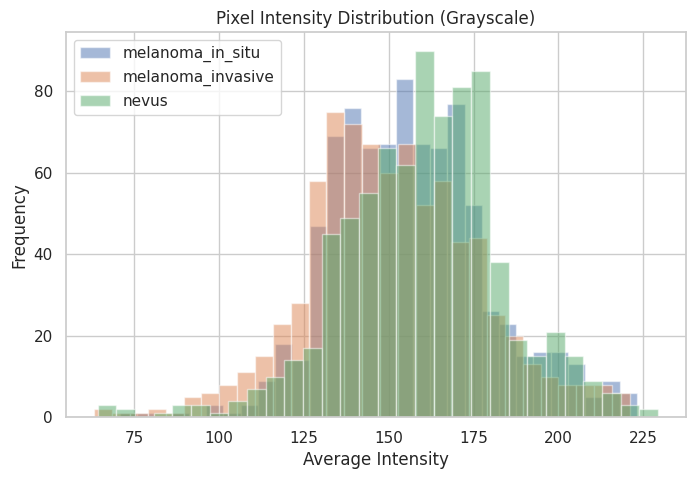

In [14]:
def avg_intensity(img_path):
    img = Image.open(img_path).convert("L")
    return np.mean(np.array(img))

df['avg_intensity'] = df['image_path'].apply(avg_intensity)

plt.figure(figsize=(8,5))
for cls in df['label'].unique():
    subset = df[df['label'] == cls]
    plt.hist(subset['avg_intensity'], bins=30, alpha=0.5, label=cls)
plt.legend()
plt.title("Pixel Intensity Distribution (Grayscale)")
plt.xlabel("Average Intensity")
plt.ylabel("Frequency")
plt.show()


### Color Channel Mean Analysis


100%|██████████| 100/100 [00:00<00:00, 681.79it/s]


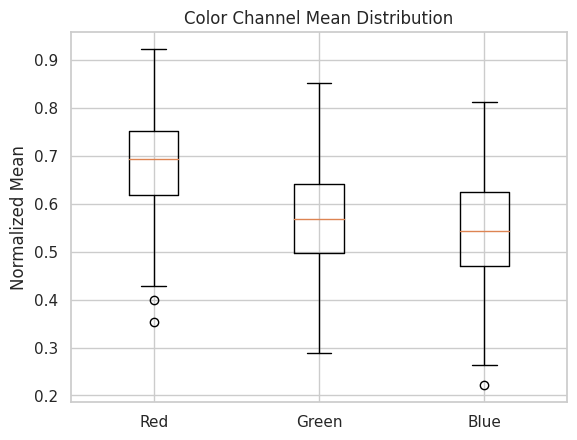

In [15]:
means = {'R': [], 'G': [], 'B': []}

for path in tqdm(df['image_path'].sample(100)):  # sample for speed
    img = np.array(Image.open(path).convert("RGB")) / 255.0
    means['R'].append(np.mean(img[:,:,0]))
    means['G'].append(np.mean(img[:,:,1]))
    means['B'].append(np.mean(img[:,:,2]))

plt.boxplot([means['R'], means['G'], means['B']], labels=['Red', 'Green', 'Blue'])
plt.title("Color Channel Mean Distribution")
plt.ylabel("Normalized Mean")
plt.show()


In [17]:

# -----------------------------
# User-editable hyperparams
# -----------------------------
DATA_ROOT = Path('/kaggle/input/melanoma-balanced-resized-verion-04/melanoma_balanced_resized_verion 04')
NUM_CLASSES = 3
CLASS_NAMES = ['nevus', 'melanoma_in_situ', 'melanoma_invasive']
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
LR = 3e-5
SEED = 42
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_NAME = 'deit_base_distilled_patch16_224'



# -----------------------------
# Reproducibility
# -----------------------------
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE == 'cuda':
    torch.cuda.manual_seed_all(SEED)


In [18]:

# -----------------------------
# Dataset class
# -----------------------------
class SkinDataset(Dataset):
    def __init__(self, filepaths, labels, transform=None):
        self.filepaths = filepaths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        import cv2
        p = self.filepaths[idx]
        img = cv2.imread(p)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=img)
            img = augmented['image']
        else:
            img = T.ToTensor()(img)
        label = self.labels[idx]
        return img, label, str(p)


In [19]:

# -----------------------------
# Build file lists and labels
# -----------------------------
all_files = []
all_labels = []
for i, cname in enumerate(CLASS_NAMES):
    folder = DATA_ROOT / cname
    files = sorted(glob(str(folder / "*")))
    all_files += files
    all_labels += [i] * len(files)

print('Total images:', len(all_files))
print('Class distribution:', Counter(all_labels))

print()

# Train/val/test split
train_files, test_files, train_labels, test_labels = train_test_split(
    all_files, all_labels, test_size=0.15, random_state=SEED, stratify=all_labels)
train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.1765, random_state=SEED, stratify=train_labels)

print('Train', Counter(train_labels), 'Val', Counter(val_labels), 'Test', Counter(test_labels))

Total images: 2447
Class distribution: Counter({1: 850, 0: 800, 2: 797})

Train Counter({1: 595, 0: 560, 2: 557}) Val Counter({1: 127, 0: 120, 2: 120}) Test Counter({1: 128, 0: 120, 2: 120})


In [20]:
# Sanity check: show numeric label mapping

print("\nClass label mapping:")
for i, cname in enumerate(CLASS_NAMES):
    print(f"  {i} → {cname}")



Class label mapping:
  0 → nevus
  1 → melanoma_in_situ
  2 → melanoma_invasive


In [21]:

# -----------------------------
# Augmentations
# -----------------------------
train_transform = A.Compose([
    A.RandomResizedCrop((IMG_SIZE, IMG_SIZE), scale=(0.8, 1.0), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    # A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.Affine(translate_percent=0.05, scale=(0.9, 1.1), rotate=(-15, 15), p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [22]:

# -----------------------------
# Datasets & Dataloaders
# -----------------------------
train_dataset = SkinDataset(train_files, train_labels, transform=train_transform)
val_dataset = SkinDataset(val_files, val_labels, transform=val_transform)
test_dataset = SkinDataset(test_files, test_labels, transform=val_transform)

class_sample_count = np.array([len([l for l in train_labels if l == i]) for i in range(NUM_CLASSES)])
weight = 1.0 / class_sample_count
samples_weight = np.array([weight[t] for t in train_labels])
samples_weight = torch.from_numpy(samples_weight).double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [23]:

# -----------------------------
# Model setup
# -----------------------------
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=NUM_CLASSES)
model.to(DEVICE)

class_counts = class_sample_count
inv_freq = class_counts.sum() / (NUM_CLASSES * class_counts)
class_weights = torch.tensor(inv_freq, dtype=torch.float).to(DEVICE)
print('Class weights (inverse frequency):', class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)


model.safetensors:   0%|          | 0.00/349M [00:00<?, ?B/s]

Class weights (inverse frequency): tensor([1.0190, 0.9591, 1.0245], device='cuda:0')


In [24]:

# -----------------------------
# Training & Validation
# -----------------------------
best_val_f1 = 0.0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss, running_acc = 0.0, 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} - Train")
    for imgs, labels, _ in pbar:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        running_acc += (preds == labels).sum().item()
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_acc / len(train_dataset)

    # Validation
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    all_preds, all_probs, all_targets = [], [], []
    with torch.no_grad():
        for imgs, labels, _ in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            probs = torch.softmax(outputs, dim=1)
            preds = probs.argmax(dim=1)
            val_acc += (preds == labels).sum().item()
            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
            all_targets.append(labels.cpu().numpy())
    val_loss /= len(val_dataset)
    val_acc /= len(val_dataset)
    all_preds = np.concatenate(all_preds)
    all_probs = np.concatenate(all_probs)
    all_targets = np.concatenate(all_targets)

    from sklearn.metrics import f1_score
    val_f1 = f1_score(all_targets, all_preds, average='macro')

    print(f"Epoch {epoch}: train_loss={epoch_loss:.4f}, val_loss={val_loss:.4f}, train_acc={epoch_acc:.4f}, val_acc={val_acc:.4f}, val_f1={val_f1:.4f}")

    history['train_loss'].append(epoch_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(epoch_acc)
    history['val_acc'].append(val_acc)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_deit_distilled.pth')
        print('Best model saved with val_f1=', best_val_f1)

    scheduler.step()


Epoch 1/20 - Train: 100%|██████████| 54/54 [00:36<00:00,  1.48it/s]


Epoch 1: train_loss=0.9018, val_loss=0.8870, train_acc=0.5607, val_acc=0.5722, val_f1=0.5785
Best model saved with val_f1= 0.5785462753122137


Epoch 2/20 - Train: 100%|██████████| 54/54 [00:36<00:00,  1.49it/s]


Epoch 2: train_loss=0.7015, val_loss=0.7379, train_acc=0.6898, val_acc=0.6621, val_f1=0.6622
Best model saved with val_f1= 0.662213283059678


Epoch 3/20 - Train: 100%|██████████| 54/54 [00:36<00:00,  1.49it/s]


Epoch 3: train_loss=0.6041, val_loss=0.8138, train_acc=0.7506, val_acc=0.6458, val_f1=0.6364


Epoch 4/20 - Train: 100%|██████████| 54/54 [00:36<00:00,  1.48it/s]


Epoch 4: train_loss=0.5025, val_loss=0.7475, train_acc=0.7961, val_acc=0.6676, val_f1=0.6696
Best model saved with val_f1= 0.6695984500837889


Epoch 5/20 - Train: 100%|██████████| 54/54 [00:36<00:00,  1.46it/s]


Epoch 5: train_loss=0.3828, val_loss=0.7299, train_acc=0.8540, val_acc=0.6866, val_f1=0.6921
Best model saved with val_f1= 0.6921395373547748


Epoch 6/20 - Train: 100%|██████████| 54/54 [00:36<00:00,  1.49it/s]


Epoch 6: train_loss=0.2825, val_loss=0.7772, train_acc=0.9013, val_acc=0.7030, val_f1=0.6986
Best model saved with val_f1= 0.698633851575028


Epoch 7/20 - Train: 100%|██████████| 54/54 [00:36<00:00,  1.49it/s]


Epoch 7: train_loss=0.2477, val_loss=0.7741, train_acc=0.9223, val_acc=0.7030, val_f1=0.7061
Best model saved with val_f1= 0.7061251446427838


Epoch 8/20 - Train: 100%|██████████| 54/54 [00:36<00:00,  1.47it/s]


Epoch 8: train_loss=0.1690, val_loss=0.7514, train_acc=0.9486, val_acc=0.7166, val_f1=0.7180
Best model saved with val_f1= 0.7179945625013171


Epoch 9/20 - Train: 100%|██████████| 54/54 [00:38<00:00,  1.42it/s]


Epoch 9: train_loss=0.1343, val_loss=0.7769, train_acc=0.9626, val_acc=0.7302, val_f1=0.7326
Best model saved with val_f1= 0.7326352995031128


Epoch 10/20 - Train: 100%|██████████| 54/54 [00:36<00:00,  1.47it/s]


Epoch 10: train_loss=0.0808, val_loss=0.7653, train_acc=0.9819, val_acc=0.7330, val_f1=0.7326


Epoch 11/20 - Train: 100%|██████████| 54/54 [00:36<00:00,  1.49it/s]


Epoch 11: train_loss=0.0655, val_loss=0.9080, train_acc=0.9836, val_acc=0.7275, val_f1=0.7295


Epoch 12/20 - Train: 100%|██████████| 54/54 [00:36<00:00,  1.49it/s]


Epoch 12: train_loss=0.0541, val_loss=0.8775, train_acc=0.9895, val_acc=0.7330, val_f1=0.7340
Best model saved with val_f1= 0.7340445885426163


Epoch 13/20 - Train: 100%|██████████| 54/54 [00:36<00:00,  1.49it/s]


Epoch 13: train_loss=0.0509, val_loss=0.8381, train_acc=0.9877, val_acc=0.7248, val_f1=0.7262


Epoch 14/20 - Train: 100%|██████████| 54/54 [00:36<00:00,  1.50it/s]


Epoch 14: train_loss=0.0342, val_loss=0.8618, train_acc=0.9942, val_acc=0.7411, val_f1=0.7431
Best model saved with val_f1= 0.7430804232997916


Epoch 15/20 - Train: 100%|██████████| 54/54 [00:36<00:00,  1.49it/s]


Epoch 15: train_loss=0.0260, val_loss=0.8539, train_acc=0.9965, val_acc=0.7302, val_f1=0.7328


Epoch 16/20 - Train: 100%|██████████| 54/54 [00:36<00:00,  1.49it/s]


Epoch 16: train_loss=0.0308, val_loss=0.8914, train_acc=0.9918, val_acc=0.7384, val_f1=0.7391


Epoch 17/20 - Train: 100%|██████████| 54/54 [00:36<00:00,  1.48it/s]


Epoch 17: train_loss=0.0221, val_loss=0.9047, train_acc=0.9982, val_acc=0.7357, val_f1=0.7370


Epoch 18/20 - Train: 100%|██████████| 54/54 [00:36<00:00,  1.47it/s]


Epoch 18: train_loss=0.0175, val_loss=0.8932, train_acc=0.9971, val_acc=0.7302, val_f1=0.7319


Epoch 19/20 - Train: 100%|██████████| 54/54 [00:36<00:00,  1.48it/s]


Epoch 19: train_loss=0.0146, val_loss=0.8959, train_acc=1.0000, val_acc=0.7330, val_f1=0.7345


Epoch 20/20 - Train: 100%|██████████| 54/54 [00:36<00:00,  1.49it/s]


Epoch 20: train_loss=0.0186, val_loss=0.9002, train_acc=0.9971, val_acc=0.7302, val_f1=0.7318


In [28]:
# !pip install grad-cam


Testing: 100%|██████████| 12/12 [00:03<00:00,  3.81it/s]


Classification Report:
                   precision    recall  f1-score   support

            nevus     0.8416    0.7083    0.7692       120
 melanoma_in_situ     0.6443    0.7500    0.6931       128
melanoma_invasive     0.7288    0.7167    0.7227       120

         accuracy                         0.7255       368
        macro avg     0.7382    0.7250    0.7284       368
     weighted avg     0.7362    0.7255    0.7276       368

Confusion Matrix:
 [[85 27  8]
 [ 8 96 24]
 [ 8 26 86]]
ROC AUC per class:
nevus 0.9100470430107527
melanoma_in_situ 0.8519856770833334
melanoma_invasive 0.8714717741935484
Micro AUC: 0.8800175744328923


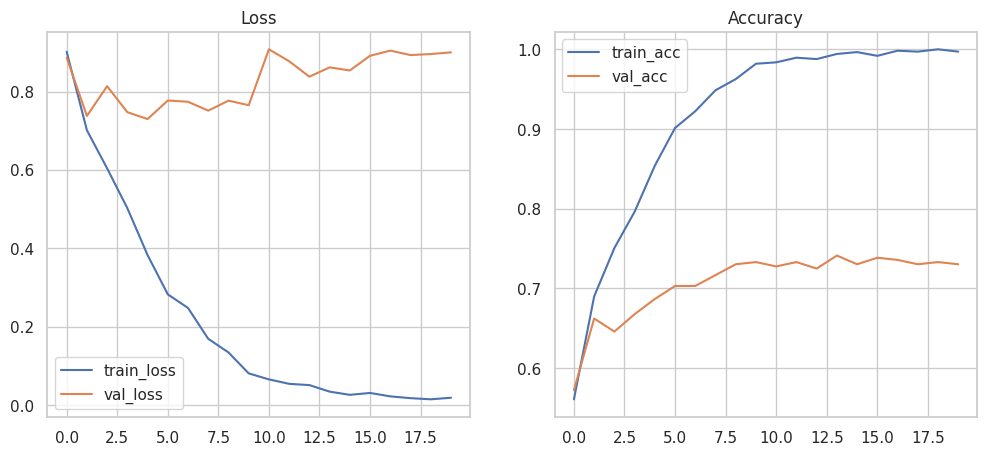

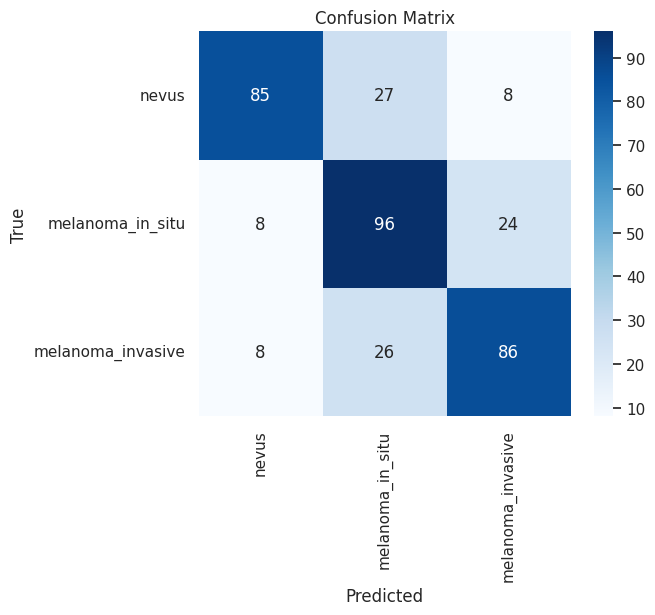

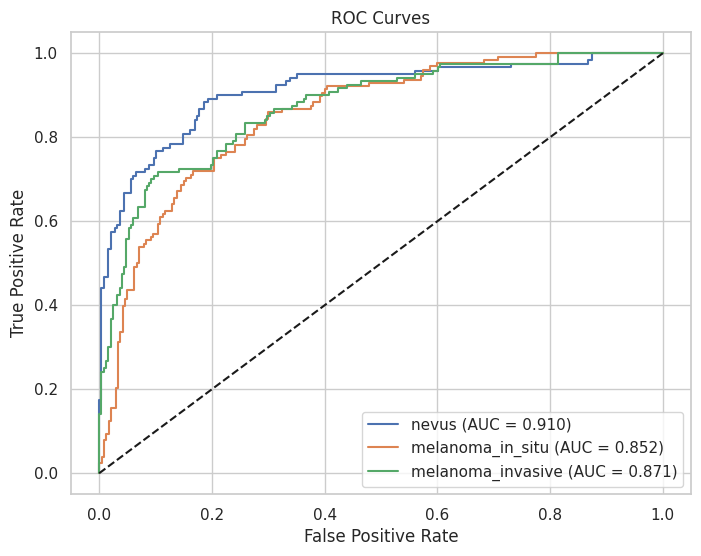

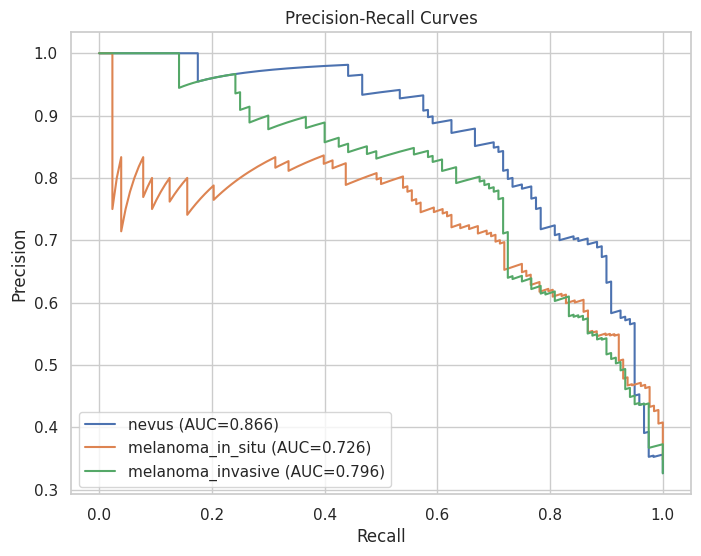

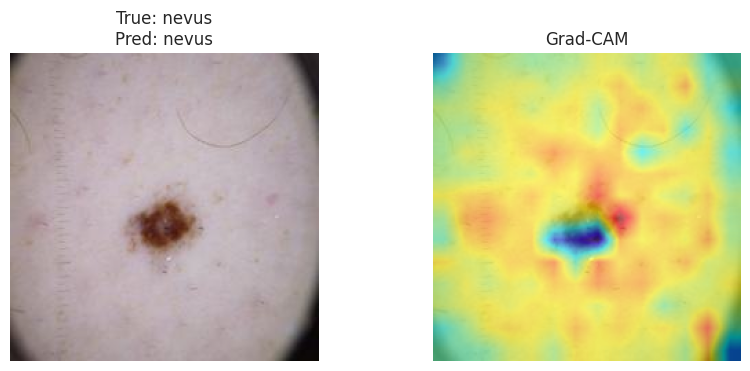

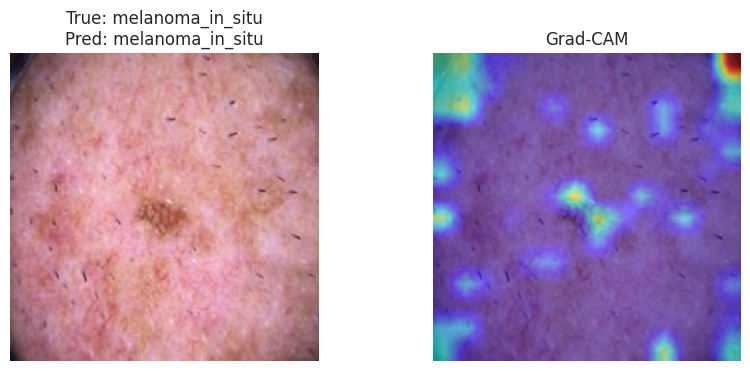

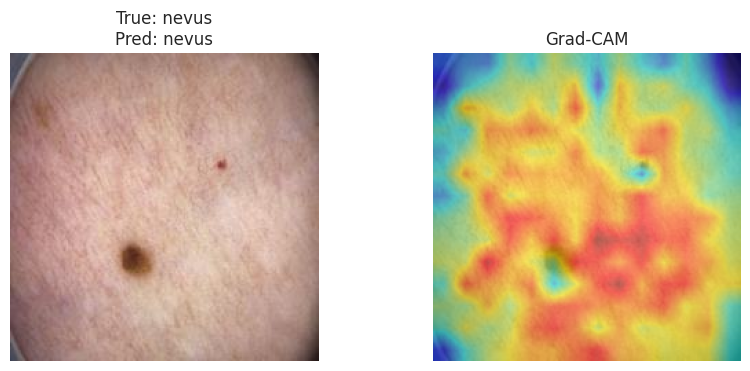

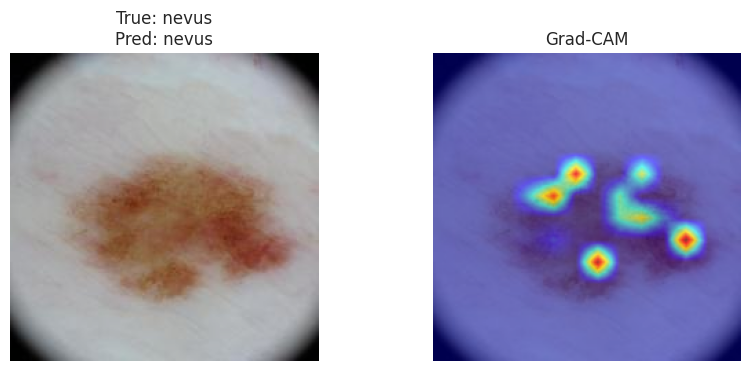

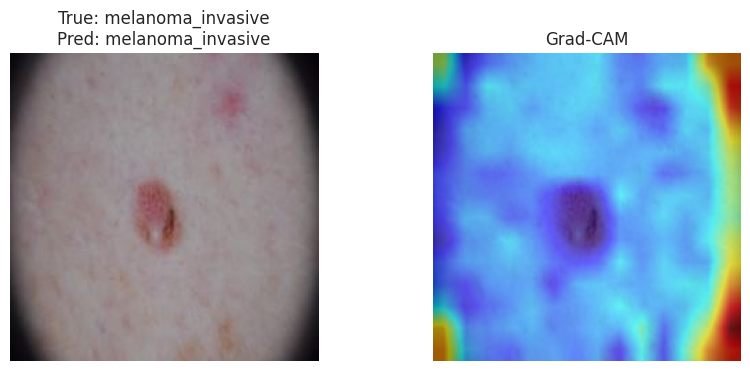

In [41]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from tqdm import tqdm

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# -----------------------------
# Helper functions
# -----------------------------
imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
imagenet_std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def denormalize(img_tensor):
    return (img_tensor * imagenet_std + imagenet_mean).clamp(0,1)

# -----------------------------
# Load model and target layer for Grad-CAM
# -----------------------------
model.load_state_dict(torch.load('best_deit_distilled.pth'))
model.to(DEVICE)
model.eval()

target_layer = model.blocks[-1].norm1  # for DeiT ViT, adjust if needed

# -----------------------------
# Evaluation: get preds, probs, targets, paths
# -----------------------------
all_preds, all_probs, all_targets, all_paths = [], [], [], []
with torch.no_grad():
    for imgs, labels, paths in tqdm(test_loader, desc='Testing'):
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        all_probs.append(probs)
        all_preds.append(preds)
        all_targets.append(labels.numpy())
        all_paths += paths

all_probs = np.concatenate(all_probs)
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

# -----------------------------
# Metrics: Classification Report & Confusion Matrix
# -----------------------------
print('Classification Report:')
print(classification_report(all_targets, all_preds, target_names=CLASS_NAMES, digits=4))

cm = confusion_matrix(all_targets, all_preds)
print('Confusion Matrix:\n', cm)

# -----------------------------
# ROC and Precision-Recall calculations
# -----------------------------
binarized = label_binarize(all_targets, classes=list(range(NUM_CLASSES)))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(binarized[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr['micro'], tpr['micro'], _ = roc_curve(binarized.ravel(), all_probs.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

print('ROC AUC per class:')
for i, name in enumerate(CLASS_NAMES):
    print(name, roc_auc[i])
print('Micro AUC:', roc_auc['micro'])

precision, recall, pr_auc = {}, {}, {}
for i in range(NUM_CLASSES):
    precision[i], recall[i], _ = precision_recall_curve(binarized[:, i], all_probs[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

# -----------------------------
# Plot Loss/Accuracy Curves (assumes history dict)
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='train_acc')
plt.plot(history['val_acc'], label='val_acc')
plt.title('Accuracy')
plt.legend()
plt.savefig('loss_acc_curves.png', dpi=150)
plt.show()

# Confusion Matrix heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

# ROC Curves
plt.figure(figsize=(8,6))
for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], label=f"{CLASS_NAMES[i]} (AUC = {roc_auc[i]:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.savefig('roc_curves.png', dpi=150)
plt.show()

# Precision-Recall Curves
plt.figure(figsize=(8,6))
for i in range(NUM_CLASSES):
    plt.plot(recall[i], precision[i], label=f"{CLASS_NAMES[i]} (AUC={pr_auc[i]:.3f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.savefig('pr_curves.png', dpi=150)
plt.show()

# -----------------------------
# Grad-CAM visualization
# -----------------------------
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
target_layer = model.patch_embed.proj  # Conv2d layer with 4D output

cam = GradCAM(model=model, target_layers=[target_layer])

num_to_show = 5  # Number of test images to visualize Grad-CAM for
shown = 0

for imgs, labels, paths in test_loader:
    imgs = imgs.to(DEVICE)
    outputs = model(imgs)
    probs = torch.softmax(outputs, dim=1)
    preds = probs.argmax(dim=1)

    for i in range(imgs.size(0)):
        if shown >= num_to_show:
            break

        img_tensor = imgs[i].cpu()
        img_denorm = denormalize(img_tensor).permute(1,2,0).numpy()

        pred_class = preds[i].item()
        true_class = labels[i].item()

        targets = [ClassifierOutputTarget(pred_class)]
        grayscale_cam = cam(input_tensor=imgs[i].unsqueeze(0), targets=targets)[0]

        visualization = show_cam_on_image(img_denorm, grayscale_cam, use_rgb=True)

        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.imshow(img_denorm)
        plt.title(f"True: {CLASS_NAMES[true_class]}\nPred: {CLASS_NAMES[pred_class]}")
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(visualization)
        plt.title("Grad-CAM")
        plt.axis('off')

        plt.savefig(f'gradcam_{shown}_true_{CLASS_NAMES[true_class]}_pred_{CLASS_NAMES[pred_class]}.png', dpi=150)
        plt.show()

        shown += 1
    if shown >= num_to_show:
        break
